In [1]:
%load_ext autoreload

In [2]:
autoreload 2

In [3]:
import sys
# !{sys.executable} -m pip install -r ../../requirements.txt

In [4]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

helper_path = os.path.abspath(os.path.join('../helper'))
if helper_path not in sys.path:
    sys.path.append(helper_path)

from helper.dataclass import HDDDataset
from helper.models.mymodel import MyModel
from helper.models.XCL import WeightedXCL
from helper.preprocessing import *
from helper.metrics import *
from helper.eda import *
from sklearn.model_selection import train_test_split
from helper.metrics import *
from helper.saver import Saver

## Data preprocessing

In [10]:
hdd_dataset = HDDDataset.read_csv('ST14000NM001G.csv')

In [11]:
preprocessor = Preprocessing(hdd_dataset)
preprocessor.clear_unused_data()
preprocessor.add_target_column()
preprocessor.prepare_train_df()
preprocessor.add_time_features()
preprocessor.train_test_val_split(sampling_strat=0.005, oversampling='Borderline')
preprocessor.normalize_data(method='formulae', inplace=False)
preprocessor.normalize_data(method='YJ', inplace=True)

Clearing unused columns...
Adding target column...
Prepairing train dataset...
Adding time features to unsplitted dataset...
Splitting train dataset...
Overampling with BorderlineSMOTE...


c:\Users\rocke\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\over_sampling\_smote\filter.py:197: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Normalizing splitted dataset with formulae...
Normalizing splitted dataset with YJ...


## Training

In [12]:
model = WeightedXCL()
#model.fit(X_train, y_train)  # %%time
model.optimize_models_hyperparameters(preprocessor.X_train, preprocessor.y_train)
model.optimize_weights(preprocessor.X_val, preprocessor.y_val)
print(model.get_hyperparams())

=== Оптимизация гиперпараметров для XGBoost... ===
Лучшие параметры для XGBoost: {'colsample_bytree': 0.996884623716487, 'gamma': 3.0874075481385828, 'learning_rate': 0.19349594814648427, 'max_depth': 14, 'n_estimators': 394, 'reg_alpha': 0.645614570099021, 'reg_lambda': 0.8059264473611898, 'subsample': 0.569746930326021}
=== Оптимизация гиперпараметров для CatBoost... ===
Лучшие параметры для CatBoost: {'bagging_temperature': 0.749080237694725, 'border_count': 124, 'depth': 13, 'l2_leaf_reg': 8.796910002727692, 'learning_rate': 0.1890550473839461, 'n_estimators': 171, 'random_strength': 0.8119890406724053}
=== Оптимизация гиперпараметров для LightGBM... ===
Лучшие параметры для LightGBM: {'colsample_bytree': 0.9464704583099741, 'learning_rate': 0.13022300234864176, 'max_depth': 10, 'min_child_samples': 12, 'n_estimators': 199, 'num_leaves': 72, 'reg_alpha': 0.9849549260809971, 'reg_lambda': 0.9162213204002109, 'subsample': 0.6061695553391381}
{'xgboost': {'objective': 'binary:logistic

## Testing

In [13]:
preds = model.predict(preprocessor.X_test)
metrics = Metrics.get_metrics(preds, preprocessor.y_test)
print(metrics)

{'accuracy': 0.9997021923018076, 'precision': 0.9567901234567902, 'recall': 0.603112840466926, 'f1': 0.7398568019093079, 'auc_roc': 0.8015468508816362}


## Logging

In [14]:
Saver.save(model, preprocessor, metrics, save_csv=False)

c:\Users\rocke\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [16:40:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [20]:
lst1 = []
lst2 = []
lst3 = []
for name, imp in zip(preprocessor.X_test.columns, model.model_xgb.feature_importances_):
    lst1.append((name, round(imp, 3)))
for name, imp in zip(preprocessor.X_test.columns, model.model_cat.feature_importances_):
    lst2.append((name, round(imp, 3)))
for name, imp in zip(preprocessor.X_test.columns, model.model_lgbm.feature_importances_):
    lst3.append((name, imp))
print(sorted(lst1, key=lambda x: x[1]))
print(sorted(lst2, key=lambda x: x[1]))
print(sorted(lst3, key=lambda x: x[1]))

[('diff_smart_188_raw_1', 0.0), ('diff_smart_192_raw_1', 0.0), ('diff_smart_241_raw_1', 0.001), ('failure', 0.002), ('diff_smart_199_raw_1', 0.002), ('diff_smart_242_raw_1', 0.002), ('smart_9_raw_normalized', 0.002), ('smart_199_raw_normalized', 0.002), ('smart_242_raw_normalized', 0.002), ('smart_9_raw', 0.003), ('shift_smart_5_raw_1', 0.003), ('shift_smart_197_raw_1', 0.003), ('diff_smart_197_raw_1', 0.003), ('smart_192_raw_normalized', 0.003), ('smart_240_raw_normalized', 0.003), ('smart_192_raw', 0.004), ('shift_smart_9_raw_1', 0.004), ('shift_smart_199_raw_1', 0.004), ('shift_smart_241_raw_1', 0.004), ('smart_197_raw', 0.005), ('smart_242_raw', 0.005), ('smart_241_raw', 0.006), ('shift_smart_187_raw_1', 0.006), ('shift_smart_240_raw_1', 0.006), ('shift_smart_242_raw_1', 0.006), ('smart_240_raw', 0.007), ('smart_5_raw', 0.008), ('smart_199_raw', 0.008), ('smart_197_raw_normalized', 0.008), ('diff_smart_187_raw_1', 0.009), ('smart_241_raw_normalized', 0.009), ('diff_smart_9_raw_1', 

c:\Users\rocke\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\rocke\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\rocke\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\rocke\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

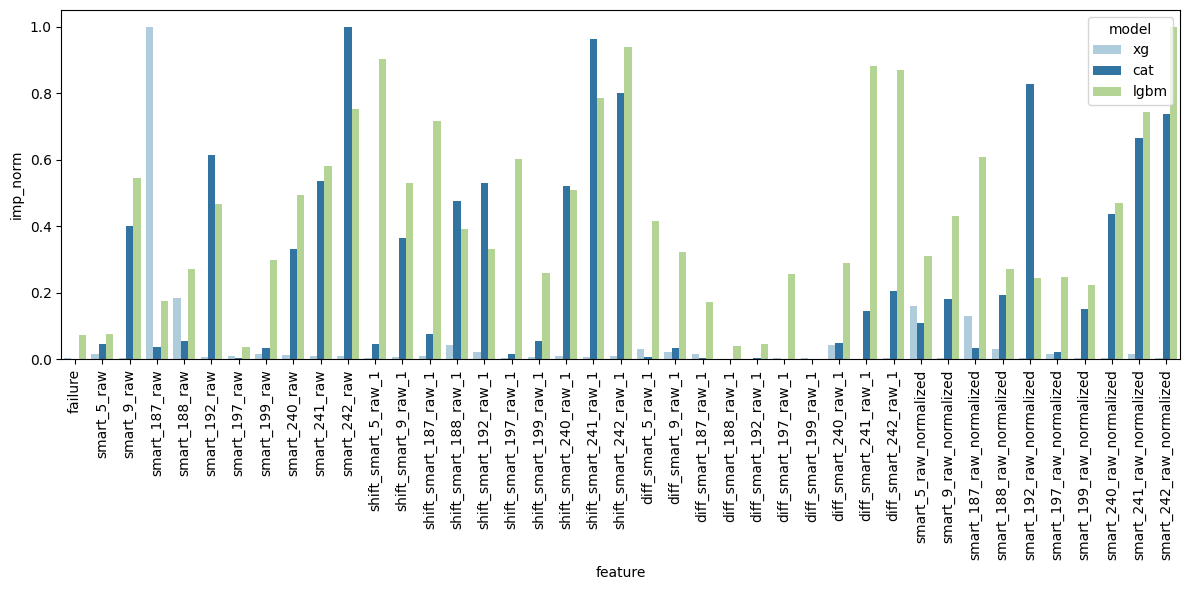

In [27]:
import seaborn as sns
data = []

for name, imp in zip(preprocessor.X_test.columns, model.model_xgb.feature_importances_):
    data.append({'model': 'xg', 'feature': name, 'imp': round(imp, 3)})
for name, imp in zip(preprocessor.X_test.columns, model.model_cat.feature_importances_):
    data.append({'model': 'cat', 'feature': name, 'imp': round(imp, 3)})
for name, imp in zip(preprocessor.X_test.columns, model.model_lgbm.feature_importances_):
    data.append({'model': 'lgbm', 'feature': name, 'imp': round(imp, 3)})
df = pd.DataFrame(data)
df['imp_norm'] = df.groupby('model')['imp'].transform(lambda x: x / x.max())
plt.figure(figsize=(12, 6))

ax = sns.barplot(x='feature', y='imp_norm', hue='model', data=df, palette='Paired')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()  # Чтобы избежать наложения текста
plt.show()